# INTRO

## (General steps) Road to pipeline
* Import neccessary libraries
    * define useful functions - (no missing values)
    * read in data
<br><br>
* filter sector-wise data
* preprocess the filtered data
    * plot sector-wise visualization
    * check for missing data
    * clean outliers
    * sector-wise groupings by volume (low/mid/high)
<br><br>
* modelling
    * hyperparameters/tunings
    * cross validation
    * feature engineering
    * prediction backtesting
<br><br>
* forecasting
    * time series pipeline

# IMPORT LIBRARIES & READ DATA

## google drive mount to colab

In [1]:
# # connect to gdrive first
# from google.colab import drive
# drive.mount('/content/gdrive')

## importing

In [1]:
import numpy as np
import pandas as pd
import math
import random
import itertools
import time

# visualization
import seaborn as sns
sns.set_style('darkgrid')

# date libraries
import datetime
import holidays
from datetime import date

# matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

# scipy library
from scipy import stats
from scipy.stats import norm

# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# prophet library
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## defining useful functions

In [2]:
# missing data
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

# mean absolute percentage error function
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''

    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## read data

In [3]:
datapath = 'relevant_stock_market_data2.csv'
# datapath = '/content/gdrive/MyDrive/Molten Trust Limited/stock market time series data/relevant_stock_market_data2.csv'

In [4]:
tsdata = pd.read_csv(datapath, parse_dates=['DATE'], index_col='DATE')

In [5]:
min(tsdata.index), max(tsdata.index)

(Timestamp('2003-01-02 00:00:00'), Timestamp('2023-02-28 00:00:00'))

In [6]:
tsdata['SECTOR'].unique()

array(['SERVICES', 'FINANCIAL SERVICES', 'NATURAL RESOURCES',
       'CONSTRUCTION/REAL ESTATE', 'OIL AND GAS', 'INDUSTRIAL GOODS',
       'CONSUMER GOODS', 'CONGLOMERATES', 'HEALTHCARE', 'AGRICULTURE',
       'ICT', 'UTILITIES'], dtype=object)

# FILTER/RESTRUCTURE

In [7]:
# filtering for agriculture stocks
filtered_stock_data = tsdata[tsdata['SECTOR'] == 'CONSUMER GOODS']

In [8]:
del filtered_stock_data['SECTOR']

In [9]:
filtered_stock_data.head()

,SYMBOL,CLOSEPRICE
DATE,,
2003-01-02,CADBURY,36.59
2003-01-03,CADBURY,37.00
2003-01-06,CADBURY,37.10
2003-01-07,CADBURY,36.55
2003-01-08,CADBURY,35.60


In [12]:
filtered_stock_data.SYMBOL.unique()


array(['CADBURY', 'CHAMPION', 'DUNLOP', 'ENAMELWA', 'FLOURMILL',
       'GOLDBREW', 'GUINNESS', 'INTBREW', 'NASCON', 'NB', 'NESTLE',
       'NNFM', 'PZ', 'UNILEVER', 'UNIONDICON', 'VITAFOAM', 'DANGSUGAR',
       'HONYFLOUR', 'MCNICHOLS', 'MULTITREX', 'BUAFOODS'], dtype=object)

In [13]:
# pivoting the Dataframe to the number of unique symbols
pivoted_tsdata = filtered_stock_data.pivot(columns='SYMBOL', values='CLOSEPRICE')
final_tsdata = pivoted_tsdata.rename(columns={'CADBURY': 'CADBURY', 'CHAMPION': 'CHAMPION', 'DUNLOP': 'DUNLOP',
                                              'ENAMELWA': 'ENAMELWA', 'FLOURMILL': 'FLOURMILL', 'GOLDBREW': 'GOLDBREW', 
                                              'GUINNESS': 'GUINNESS', 'INTBREW': 'INTBREW', 'NASCON': 'NASCON', 'NB': 'NB', 
                                              'NESTLE': 'NESTLE', 'NNFM': 'NNFM', 'PZ': 'PZ', 'UNILEVER': 'UNILEVER', 
                                              'UNIONDICON': 'UNIONDICON', 'VITAFOAM': 'VITAFOAM', 'DANGSUGAR': 'DANGSUGAR', 
                                              'HONYFLOUR': 'HONYFLOUR', 'MCNICHOLS': 'MCNICHOLS', 'MULTITREX': 'MULTITREX', 'BUAFOODS': 'BUAFOODS'})


In [14]:
# Resample the data with daily frequency by interpolation
consumer_tsdata = final_tsdata.resample('D').interpolate(method='linear')

In [15]:
consumer_tsdata.fillna(0, inplace=True)

# PREPROCESSING

## visualization

In [16]:
consumer_tsdata.head()

SYMBOL,BUAFOODS,CADBURY,CHAMPION,DANGSUGAR,DUNLOP,ENAMELWA,FLOURMILL,GOLDBREW,GUINNESS,HONYFLOUR,...,MCNICHOLS,MULTITREX,NASCON,NB,NESTLE,NNFM,PZ,UNILEVER,UNIONDICON,VITAFOAM
DATE,,,,,,,,,,,,,,,,,,,,,
2003-01-02,0.0,36.590000,0.5,0.0,2.830000,3.15,17.350000,0.54,44.010000,0.0,...,0.0,0.0,0.69,29.800000,87.500000,9.62,7.700000,15.5,7.5,6.25
2003-01-03,0.0,37.000000,0.5,0.0,2.830000,3.15,17.500000,0.54,46.150000,0.0,...,0.0,0.0,0.69,30.100000,87.500000,9.62,7.460000,15.5,7.5,6.50
2003-01-04,0.0,37.033333,0.5,0.0,2.786667,3.15,17.666667,0.54,46.866667,0.0,...,0.0,0.0,0.69,30.166667,87.666667,9.62,7.533333,15.4,7.5,6.50
2003-01-05,0.0,37.066667,0.5,0.0,2.743333,3.15,17.833333,0.54,47.583333,0.0,...,0.0,0.0,0.69,30.233333,87.833333,9.62,7.606667,15.3,7.5,6.50
2003-01-06,0.0,37.100000,0.5,0.0,2.700000,3.15,18.000000,0.54,48.300000,0.0,...,0.0,0.0,0.69,30.300000,88.000000,9.62,7.680000,15.2,7.5,6.50


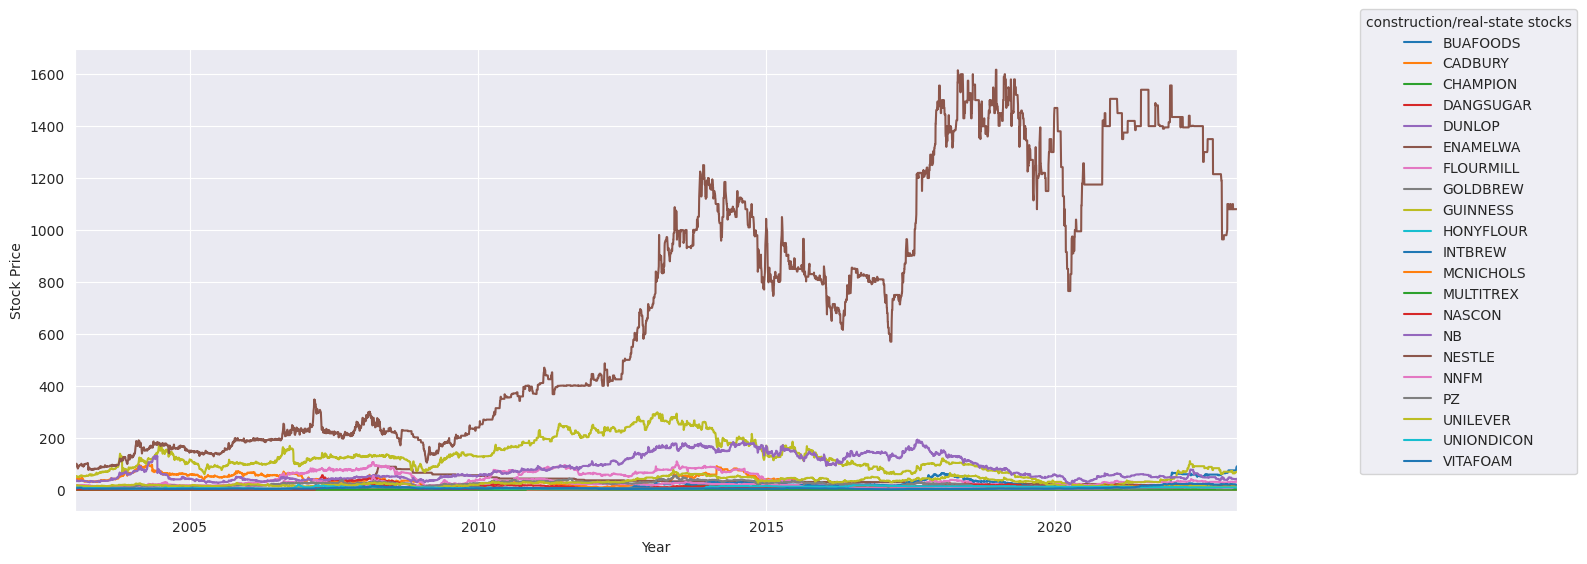

In [26]:
# Plotting
consumer_tsdata.plot(figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend(title='construction/real-state stocks', loc='best', bbox_to_anchor=(1.1, 1.1))
plt.show()

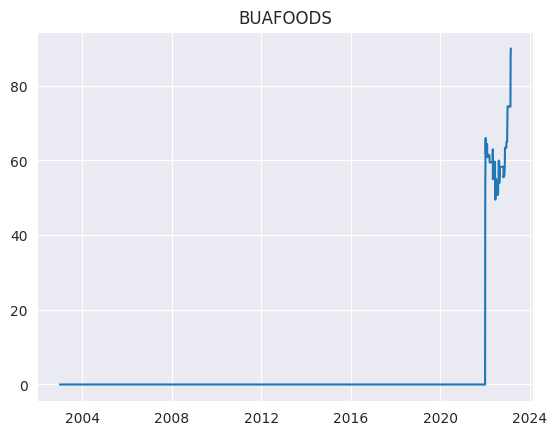

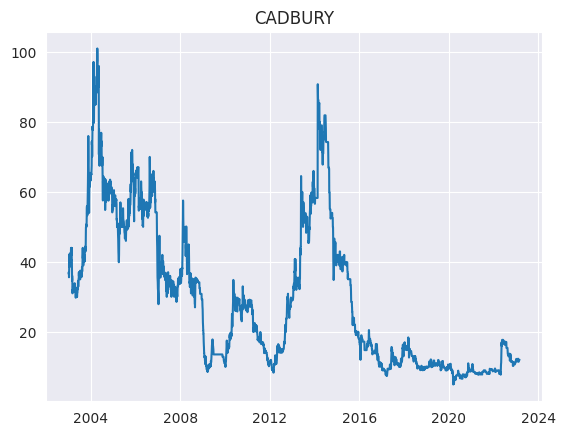

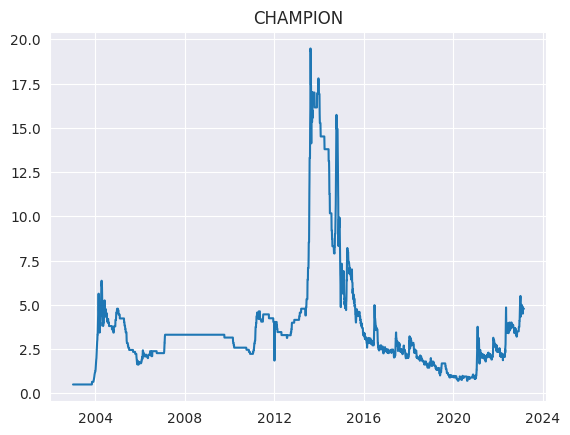

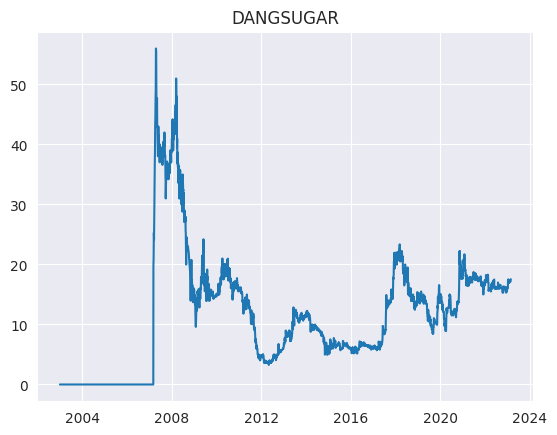

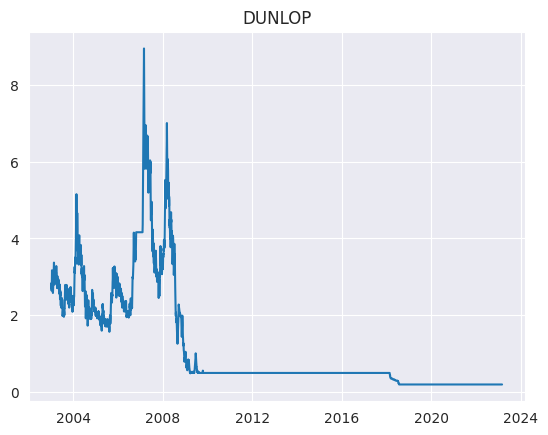

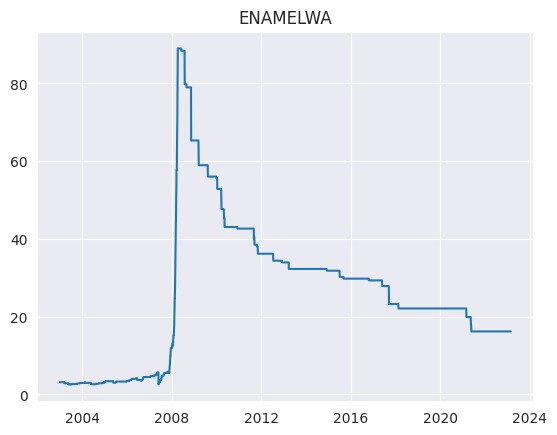

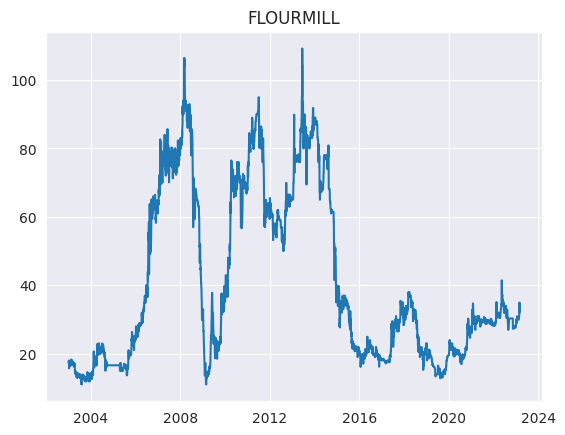

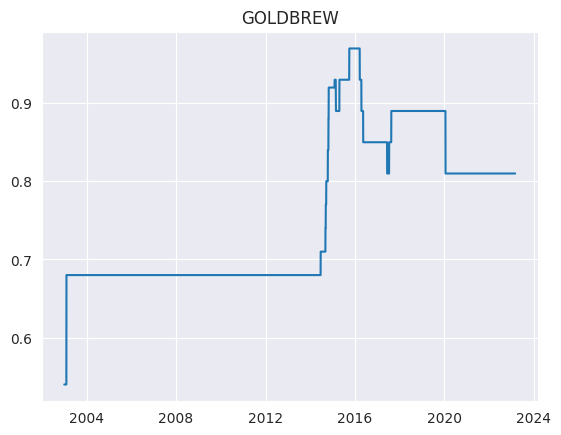

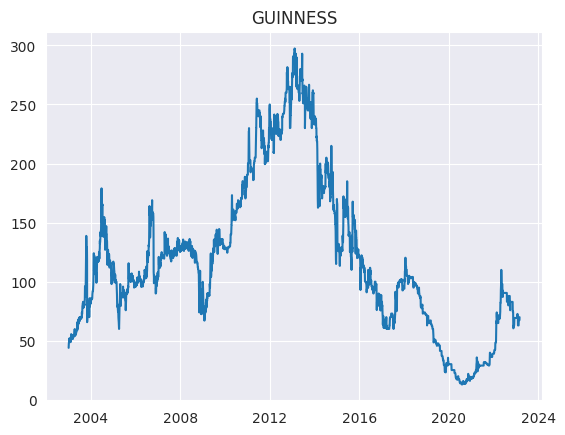

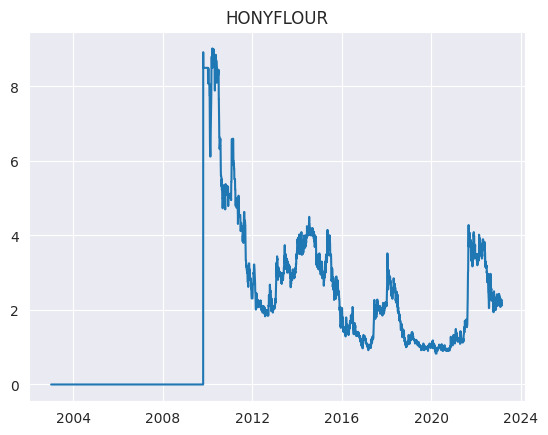

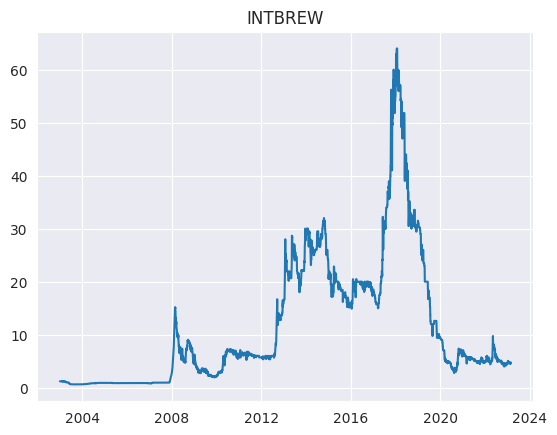

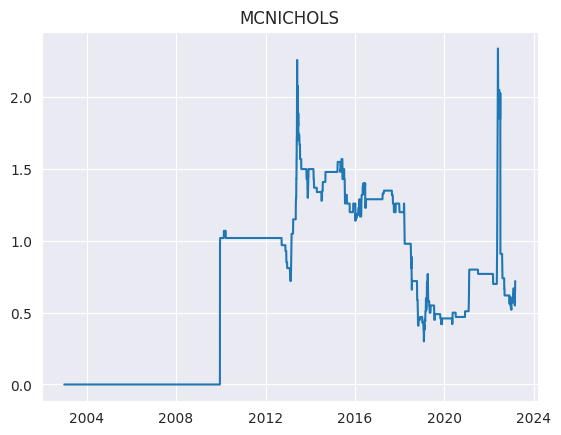

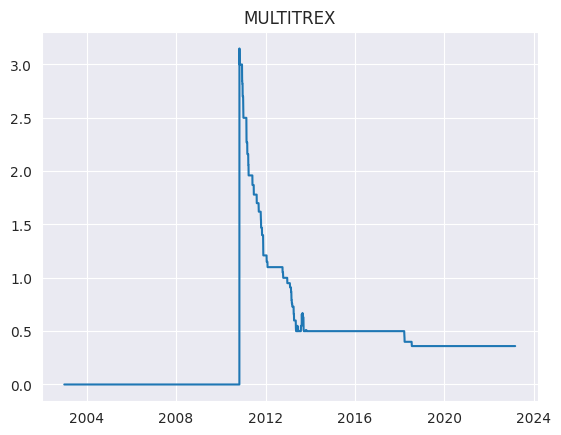

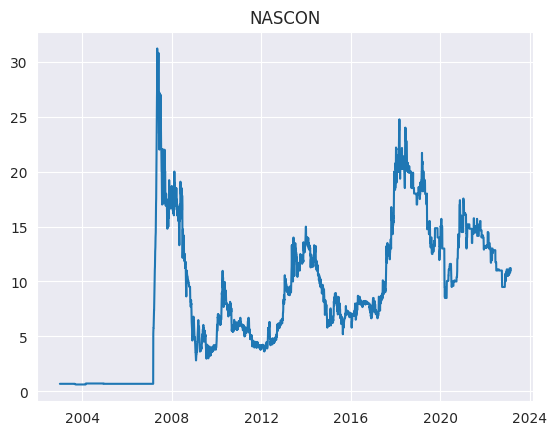

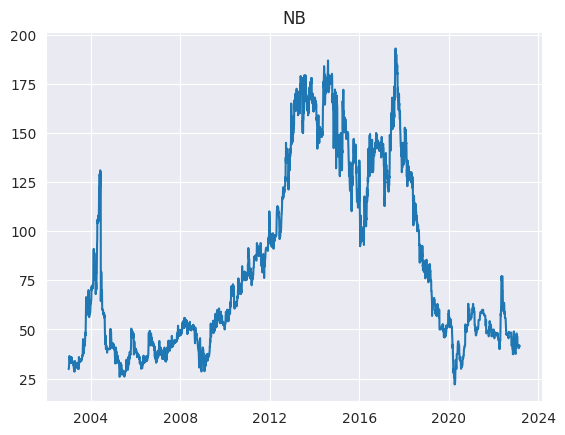

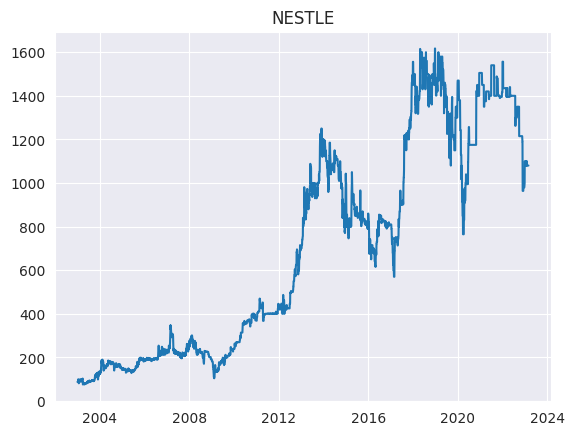

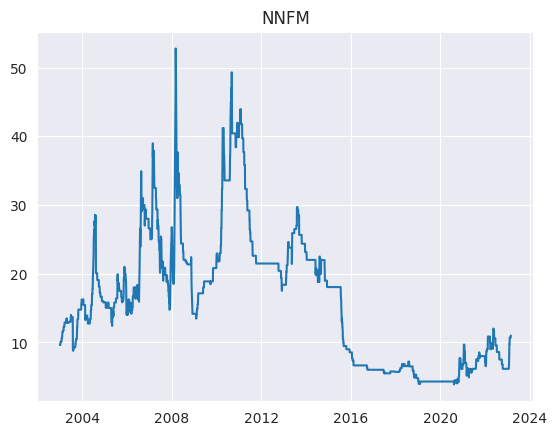

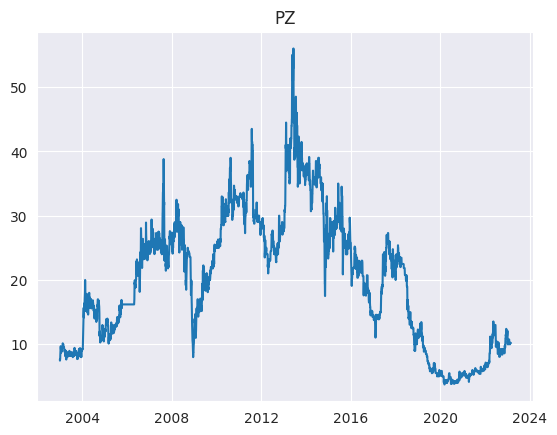

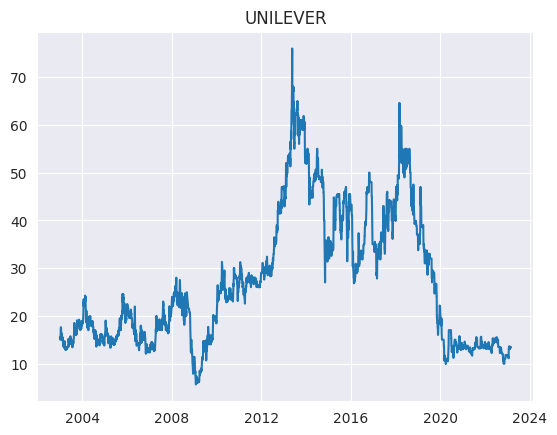

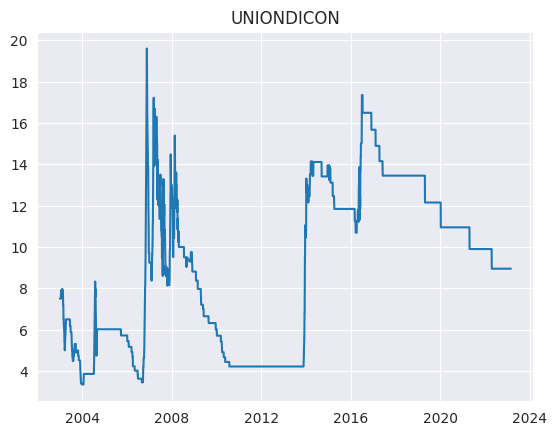

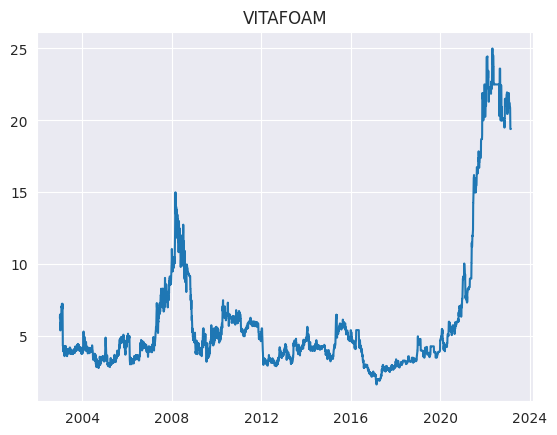

In [27]:
for column in consumer_tsdata.columns:
    plt.plot(consumer_tsdata[column])
    plt.title(column)
    plt.show()

## cleaning

In [29]:
missing_data(consumer_tsdata)

,Total,Percent,Types
SYMBOL,,,
BUAFOODS,0,0.0,float64
CADBURY,0,0.0,float64
CHAMPION,0,0.0,float64
DANGSUGAR,0,0.0,float64
DUNLOP,0,0.0,float64
ENAMELWA,0,0.0,float64
FLOURMILL,0,0.0,float64
GOLDBREW,0,0.0,float64
GUINNESS,0,0.0,float64


## outliers

<b>`Data Cleaning Requirements`</b>
* remove outliers (automated by calculating and removing <b>`z-score`</b>, while Prophet helps impute those values). This will remove the outliers near 0 for all categories.

In [30]:
# getting percentage of rows for each sector that is at 0

(consumer_tsdata == 0).astype(int).sum(axis=0)/len(consumer_tsdata.sum(axis=0))

SYMBOL
BUAFOODS      330.619048
CADBURY         0.000000
CHAMPION        0.000000
DANGSUGAR      72.666667
DUNLOP          0.000000
ENAMELWA        0.000000
FLOURMILL       0.000000
GOLDBREW        0.000000
GUINNESS        0.000000
HONYFLOUR     118.238095
INTBREW         0.000000
MCNICHOLS     121.047619
MULTITREX     136.190476
NASCON          0.000000
NB              0.000000
NESTLE          0.000000
NNFM            0.000000
PZ              0.000000
UNILEVER        0.000000
UNIONDICON      0.000000
VITAFOAM        0.000000
dtype: float64

In [33]:
# breaking out each consumer stocks into it's own dataframe
prediction_df_consumer_list = []

# cleaning up dataframe using z-score to remove outliers that heavily bias the model
for column in consumer_tsdata.columns:
    df_consumer_clean = consumer_tsdata[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_consumer_clean[column]))
    outlier_index = np.where(z > 4)[0] # As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)a
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_consumer_clean.drop(index=outlier_index,inplace=True)
    df_consumer_clean.set_index('DATE', inplace=True)
    prediction_df_consumer_list.append(df_consumer_clean)

Dropping 164 rows for following category: BUAFOODS
Dropping 0 rows for following category: CADBURY
Dropping 138 rows for following category: CHAMPION
Dropping 9 rows for following category: DANGSUGAR
Dropping 24 rows for following category: DUNLOP
Dropping 0 rows for following category: ENAMELWA
Dropping 0 rows for following category: FLOURMILL
Dropping 0 rows for following category: GOLDBREW
Dropping 0 rows for following category: GUINNESS
Dropping 0 rows for following category: HONYFLOUR
Dropping 18 rows for following category: INTBREW
Dropping 0 rows for following category: MCNICHOLS
Dropping 114 rows for following category: MULTITREX
Dropping 0 rows for following category: NASCON
Dropping 0 rows for following category: NB
Dropping 0 rows for following category: NESTLE
Dropping 0 rows for following category: NNFM
Dropping 0 rows for following category: PZ
Dropping 0 rows for following category: UNILEVER
Dropping 0 rows for following category: UNIONDICON
Dropping 0 rows for following

In [35]:
prediction_df_consumer_list

[SYMBOL       BUAFOODS
 DATE                 
 2003-01-02   0.000000
 2003-01-03   0.000000
 2003-01-04   0.000000
 2003-01-05   0.000000
 2003-01-06   0.000000
 ...               ...
 2022-11-19  57.666667
 2022-11-20  58.333333
 2022-11-21  59.000000
 2022-11-22  59.750000
 2022-11-23  59.750000
 
 [7199 rows x 1 columns],
 SYMBOL        CADBURY
 DATE                 
 2003-01-02  36.590000
 2003-01-03  37.000000
 2003-01-04  37.033333
 2003-01-05  37.066667
 2003-01-06  37.100000
 ...               ...
 2023-02-24  12.000000
 2023-02-25  12.000000
 2023-02-26  12.000000
 2023-02-27  12.000000
 2023-02-28  12.000000
 
 [7363 rows x 1 columns],
 SYMBOL      CHAMPION
 DATE                
 2003-01-02      0.50
 2003-01-03      0.50
 2003-01-04      0.50
 2003-01-05      0.50
 2003-01-06      0.50
 ...              ...
 2023-02-24      4.78
 2023-02-25      4.78
 2023-02-26      4.78
 2023-02-27      4.78
 2023-02-28      4.78
 
 [7225 rows x 1 columns],
 SYMBOL      DANGSUGAR
 DATE    

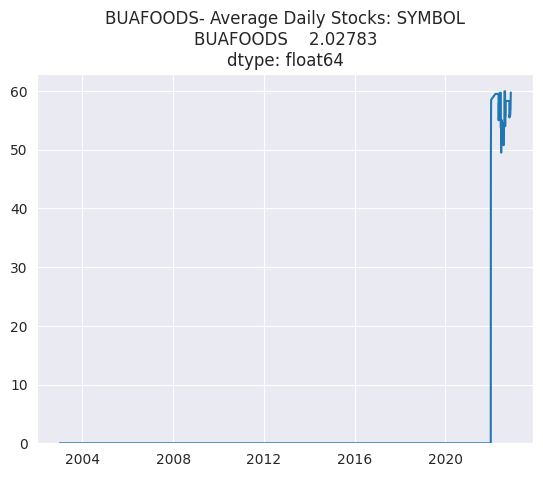

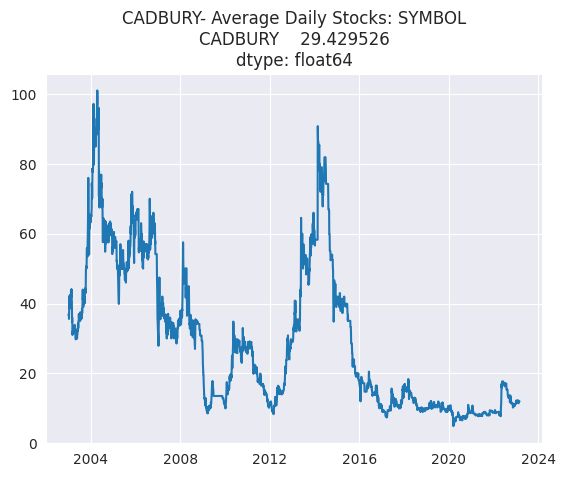

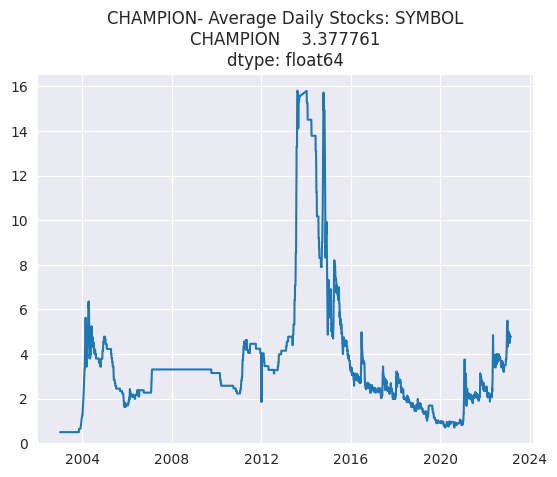

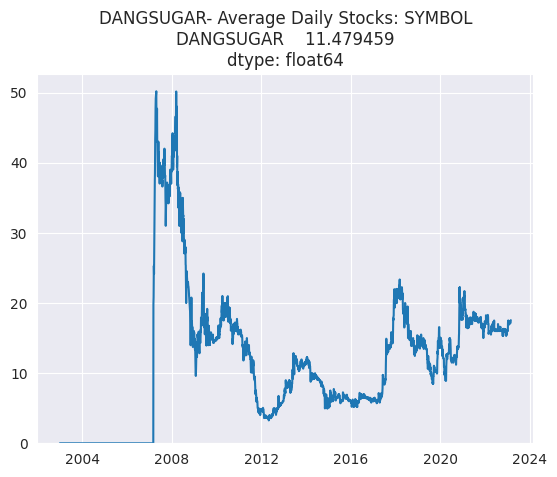

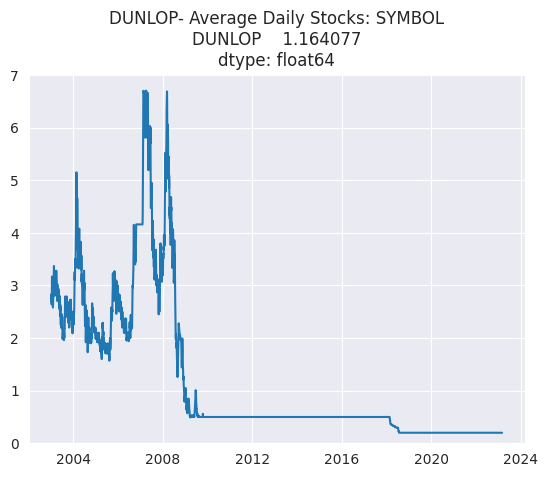

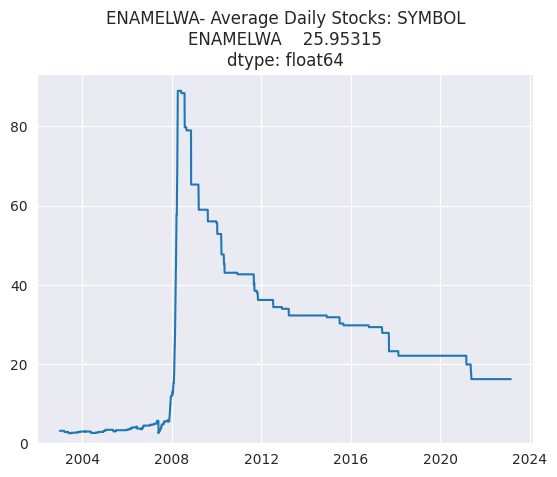

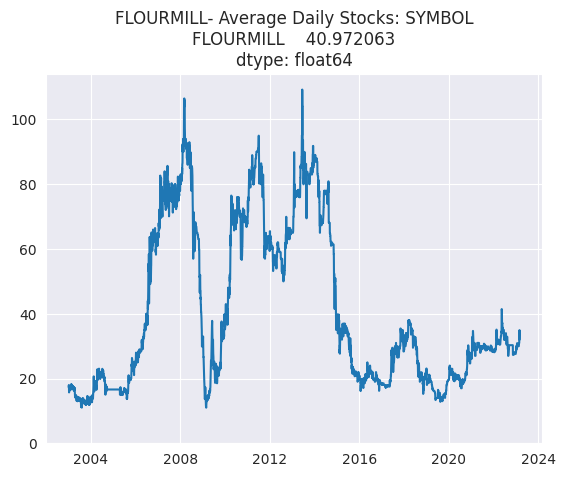

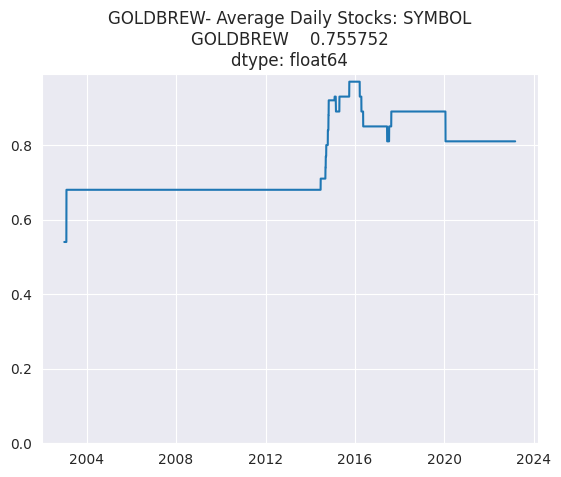

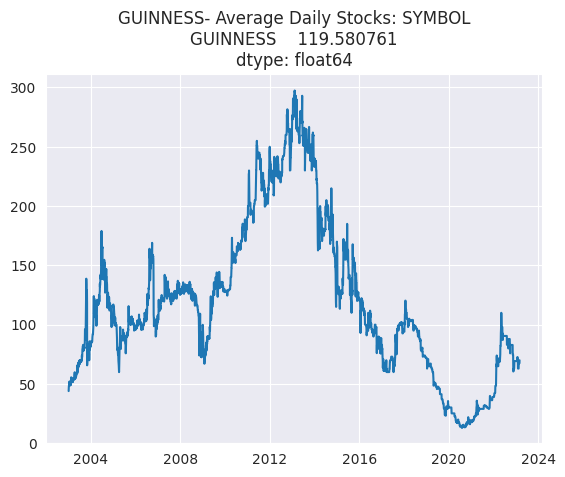

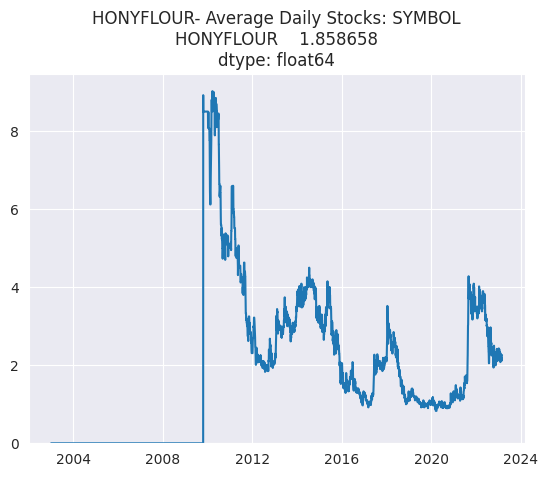

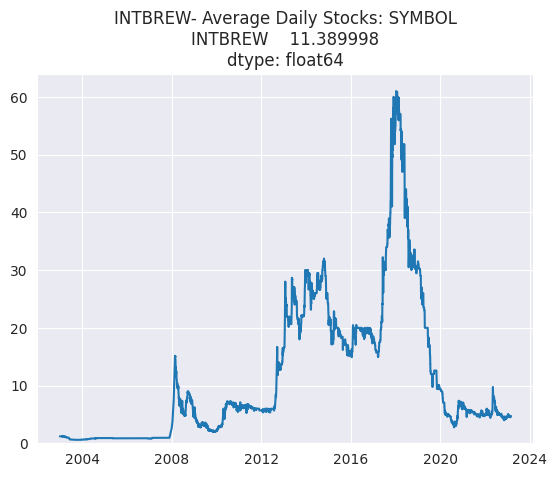

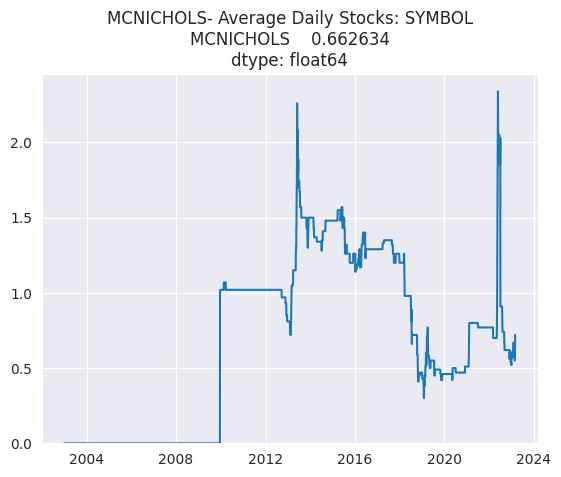

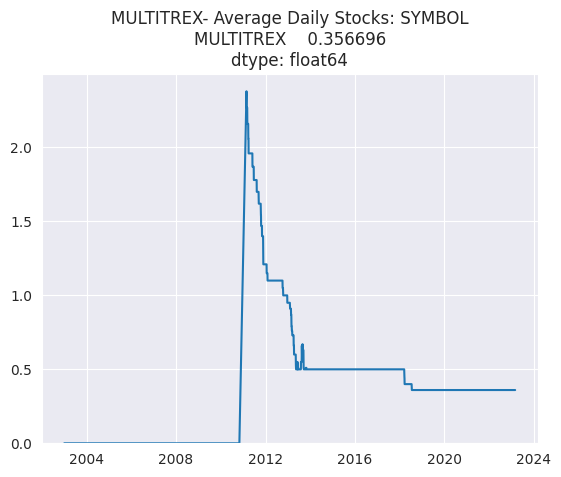

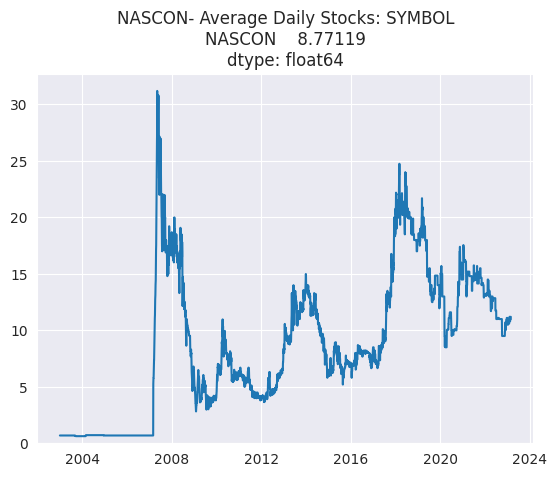

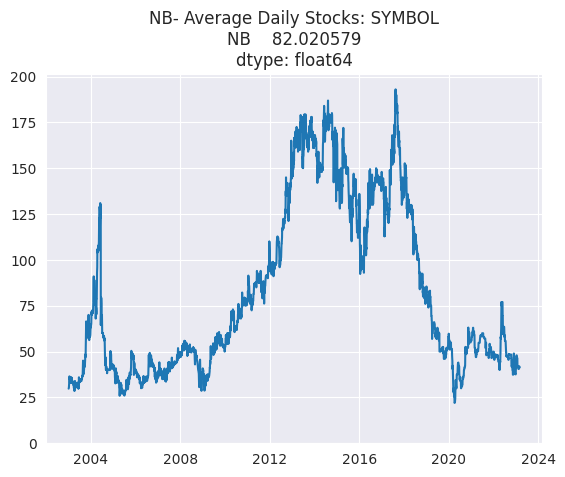

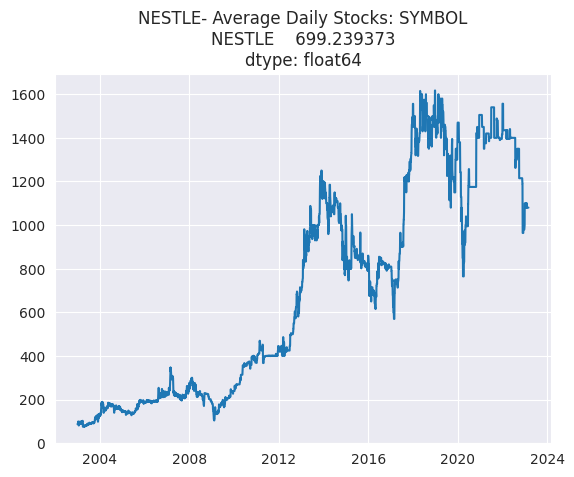

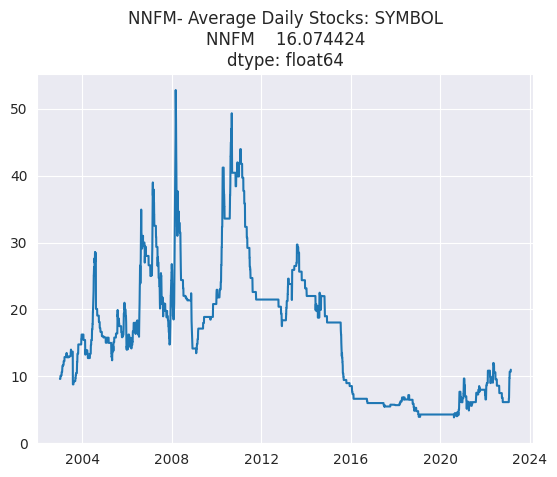

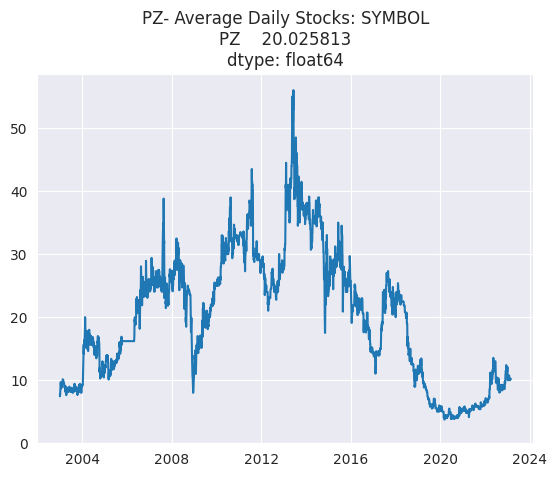

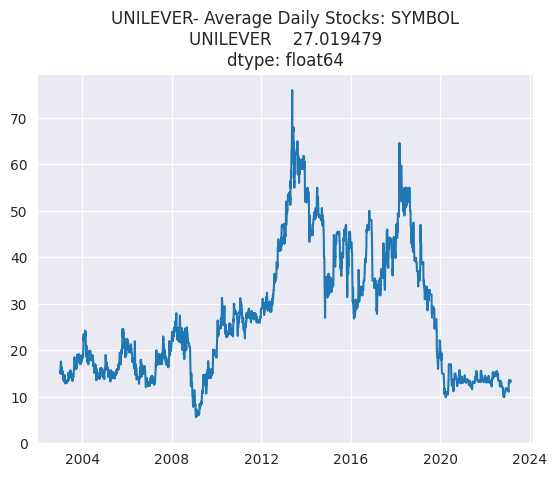

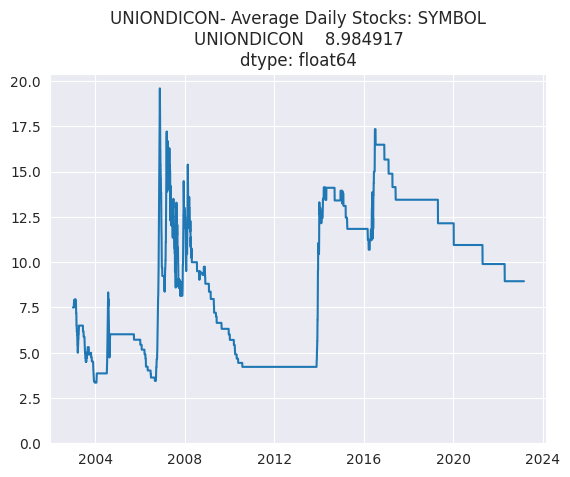

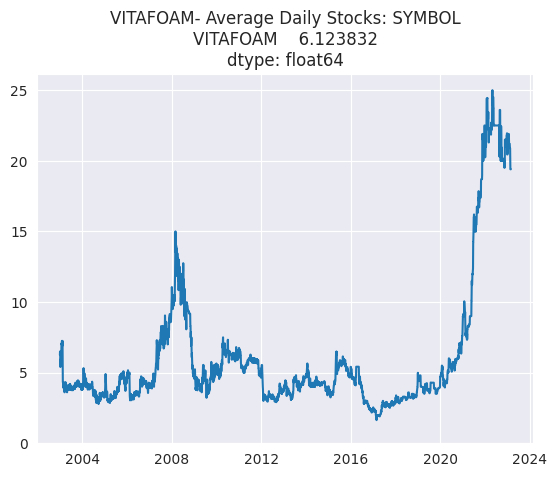

In [36]:
for i in range(len(prediction_df_consumer_list)):
    plt.plot(prediction_df_consumer_list[i])
    plt.title(prediction_df_consumer_list[i].columns[0]+'- Average Daily Stocks: '+str(prediction_df_consumer_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

## sector-wise groupings (low/mid/high)

In [37]:
average_closeprices = consumer_tsdata.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(consumer_tsdata.apply(np.mean, axis=0).sort_values(), [25, 75])

In [38]:
low_vol_cols = list(average_closeprices[average_closeprices <= low].index)
mid_vol_cols = list(average_closeprices[(average_closeprices > low) & (average_closeprices < mid)].index)
high_vol_cols = list(average_closeprices[average_closeprices >= mid].index)

In [39]:
print(f'Low volume stocks are: {low_vol_cols}')
print(f'Middle volume stocks are: {mid_vol_cols}')
print(f'High volume stocks are: {high_vol_cols}')

Low volume stocks are: ['MULTITREX', 'MCNICHOLS', 'GOLDBREW', 'DUNLOP', 'HONYFLOUR', 'BUAFOODS']
Middle volume stocks are: ['CHAMPION', 'VITAFOAM', 'NASCON', 'UNIONDICON', 'INTBREW', 'DANGSUGAR', 'NNFM', 'PZ', 'ENAMELWA']
High volume stocks are: ['UNILEVER', 'CADBURY', 'FLOURMILL', 'NB', 'GUINNESS', 'NESTLE']


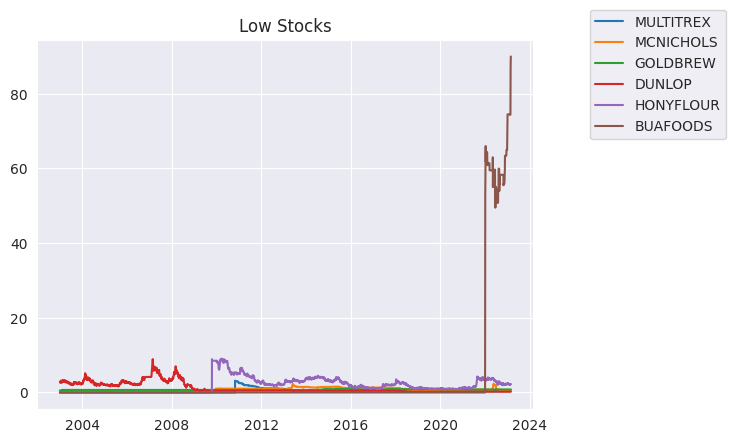

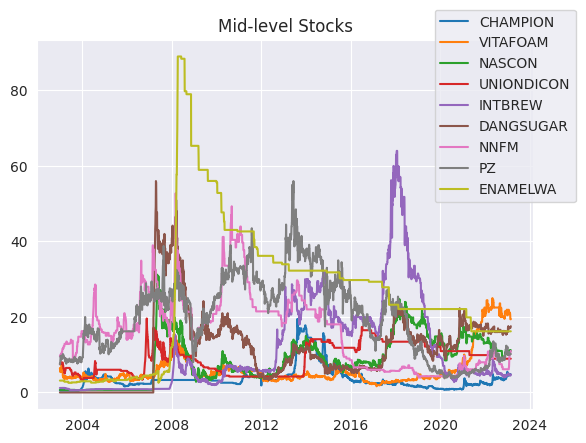

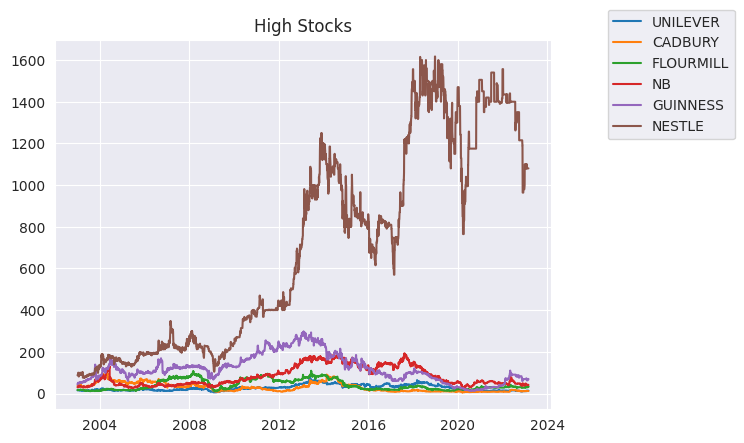

In [40]:
# constructionrs_tsdata[low_vol_cols].plot.line()
plt.plot(consumer_tsdata[low_vol_cols])
plt.legend(low_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Low Stocks")
plt.show()

plt.plot(consumer_tsdata[mid_vol_cols])
plt.legend(mid_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Mid-level Stocks")
plt.show()

plt.plot(consumer_tsdata[high_vol_cols])
plt.legend(high_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("High Stocks")
plt.show()

# MODEL BUILDING

## hyperparameter tuning

these parameters that can be tuned;

1. <b>`changepoint_prior_scale`</b>
2. <b>`seasonality_prior_scale`</b>
3. <b>`holidays_prior_scale`</b>
4. <b>`seasonality_mode`</b>
5. <b>`changepoint_range`</b>

In [41]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [42]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

seasonality_mode_options = ['additive', 'multiplicative']
# changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

<hr>

<b>`NOTE:`</b><br> in order to determine the effective accuracy of the model, in prophet cross-validation, I have to cut off the data at various times within the dates (not including the `2003`), over a large timeframe, so as to normalize. This gives rise to the importance for <b>`cross-validation`</b> 


## cross validation (prophet pipeline)

finding the <b>`"best"`</b> parameters by testing over various periods of time with those parameters (cross-validation)

In [32]:
start_time = time.time()

dicts = {}

for feature in consumer_tsdata.columns:
  
    stocksector_df = consumer_tsdata[feature].copy().reset_index()
    stocksector_df.columns = ["ds", "y"]

    stocksector_df[["y"]] = stocksector_df[["y"]].apply(pd.to_numeric)
    stocksector_df["ds"] = pd.to_datetime(stocksector_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # to generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(stocksector_df)  # fit model with given params
        df_cv = cross_validation(m, initial="365.25 days", period="365.25 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time))

21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:09,  2.02it/s]21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:01<00:11,  1.52it/s]21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:02<00:15,  1.10it/s]21:27:49 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:04<00:20,  1.27s/it]21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  39.332431  6.271557  4.150187  0.731365  0.604964  0.542277   

   coverage  
0      0.68  


21:29:46 - cmdstanpy - INFO - Chain [1] start processing
21:29:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:06,  2.85it/s]21:29:53 - cmdstanpy - INFO - Chain [1] start processing
21:29:53 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:06,  2.61it/s]21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:07,  2.18it/s]21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:10,  1.60it/s]21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse      mae      mape     mdape     smape  \
0 30 days  40.248777  6.344192  4.24156  0.750967  0.653068  0.562433   

   coverage  
0     0.665  


21:31:31 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:31:37 - cmdstanpy - INFO - Chain [1] start processing
21:31:37 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:10,  1.83it/s]21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:01<00:11,  1.62it/s]21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:11,  1.52it/s]21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:11,  1.34it/s]21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae    mape     mdape     smape  coverage
0 30 days  39.137275  6.255979  4.144125  0.7356  0.656892  0.563799  0.681667


21:33:20 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:33:24 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:07,  2.39it/s]21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:25 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:09,  1.97it/s]21:33:26 - cmdstanpy - INFO - Chain [1] start processing
21:33:26 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]21:33:27 - cmdstanpy - INFO - Chain [1] start processing
21:33:27 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:13,  1.19it/s]21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape    smape  \
0 30 days  40.535278  6.366732  4.243273  0.749784  0.625029  0.56539   

   coverage  
0  0.658333  


21:35:07 - cmdstanpy - INFO - Chain [1] start processing
21:35:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/20 [00:00<?, ?it/s]21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/20 [00:00<00:08,  2.22it/s]21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:13 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 2/20 [00:00<00:08,  2.02it/s]21:35:13 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 3/20 [00:01<00:10,  1.57it/s]21:35:14 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 4/20 [00:02<00:11,  1.34it/s]21:35:15 - cmdstanpy - INFO - Chain [1] start processing
21:35:15 - cmdstanpy - INFO - Chain [1] done processing
21:35:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Opti

  horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  39.911405  6.317547  4.195237  0.739326  0.652104  0.558775   

   coverage  
0  0.671667  


21:36:57 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

<b>`"df_p"`</b> gives the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. 

In [43]:
#how to call params_dict for a feature

dicts

NameError: name 'dicts' is not defined

## feature engineering by `holidays`

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

nigeria_holidays = holidays.NG()  # this is a dict
# the below is the same, but takes a string:
nigeria_holidays = holidays.country_holidays('NG')  # this is a dict


for date_, name in sorted(holidays.NG(years=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "NG-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

## backtesting with tuned metrics
`latest month up-to-date mape`

In [ ]:
prediction_days = 30
forecast_start_date = max(consumer_tsdata.index) - timedelta(predictions_days)

<b>Note:</b> check a documentation here (reference to repo)!

In [ ]:
# PROPHET MODEL

forecasted_tsdata = []

for feature in consumer_tsdata.columns:

    # prophet formats
    df_consumer_copy = consumer_tsdata[feature].copy().reset_index()
    df_consumer_copy.columns = ['ds', 'y']
    df_consumer_copy[['y']] = df_consumer_copy[['y']].apply(pd.to_numeric)
    df_consumer_copy['ds'] = pd.to_datetime(df_consumer_copy['ds'])
    
    df_consumer_copy_train = df_consumer_copy[df_consumer_copy['ds'] < forecast_start_date]
    
    # search & get the right param_dict for this sector
    param_dict = dicts[feature]
    
    # model
    model = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                   seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                   holidays = holiday)
    
    model.fit(df_consumer_copy_train)
    
    future = model.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds'] >= forecast_start_date
    predicted_consumer_df = fcst_prophet_train[filter]['ds', 'yhat']
    predicted_consumer_df = predicted_consumer_df.merge(df_consumer_copy)

    print(feature, mape(predicted_consumer_df['y'], predicted_consumer_df['yhat']))

# FINAL FORECASTING

## forecast pipeline!!!

In [ ]:
days_of_predictiion = 672
start_date_of_forecast = max(consumer_tsdata.index)

In [ ]:
# using prophet model technique

forecasted_dataframe = []

for feature in consumer_tsdata.columns: # plotting for first five: for feature in constructionrs_tsdata.columns[:5]:

    # formatting
    consumer_tsdata_copy = consumer_tsdata[feature].copy().reset_index()
    consumer_tsdata_copy.columns = ['ds', 'y']
    consumer_tsdata_copy[['y']] = consumer_tsdata_copy[['y']].apply(pd.to_numeric)
    consumer_tsdata_copy['ds'] = pd.to_datetime(consumer_tsdata_copy['ds'])

    consumer_tsdata_copy_train = consumer_tsdata_copy[consumer_tsdata_copy['ds'] < start_date_of_forecast]

    # search and get the rightparam_dicts for the sector
    param_dicts = dicts[feature]

    # model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                holidays = holiday)

    m.fit(consumer_copy_train)

    future_df = m.make_future_dataframe(periods = days_of_prediction)
    forecast_prophet_train = m.predict(future_df)
    
    fig1 = m.plot(forecast_prophet_train)
    fig2 = m.plot_components(forecast_prophet_train)

    forecasted_df = forecast_prophet_train[forecast_prophet_train['ds'] >= start_date_of_forecast]
    forecasted_dataframe.append(forecasted_df)

## forecasting visualization
2023 - March to December
2024 - January to December (leap year)

## Conclusions
<b>`...........................................................................................................`</b>